In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

from fastprogress import master_bar, progress_bar

from matplotlib import patches, patheffects

from pathlib import Path

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops

from scipy import ndimage

import cv2

C:\Users\chrun\Anaconda3\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\chrun\Anaconda3\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [3]:
show_install(0)



```text
=== Software === 
python version  : 3.6.6
fastai version  : 1.0.20
torch version   : 0.4.1
torch cuda ver  : 9.2
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
torch available : 1
  - gpu0        : GeForce GTX 1080

=== Environment === 
platform        : Windows-10-10.0.17134-SP0
conda env       : fastai
python          : C:\Users\chrun\Anaconda3\envs\fastai\python.exe
sys.path        : 
C:\Users\chrun\Downloads\pysc2-examples-master\pysc2-examples-master\env2\atari-py-master2
C:\Users\chrun\Anaconda3\envs\fastai\python36.zip
C:\Users\chrun\Anaconda3\envs\fastai\DLLs
C:\Users\chrun\Anaconda3\envs\fastai\lib
C:\Users\chrun\Anaconda3\envs\fastai
C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages
C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\defusedxml-0.5.0-py3.6.egg
C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\win32
C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\win32\lib
C:\Users\chrun\Anaconda3\e

## Stage 1 Dataset

In [4]:
PATH = Path('data')
TMP_PATH = "tmp/tmp"
MODEL_PATH = "tmp/model/"
sz = 128
arch = models.resnet34
bs = 128

In [5]:
train_masks_fn = f'{PATH}/train_ship_segmentations_v2.csv'
train_masks_path = Path(PATH/'train_ship_segmentations_v2.csv')

images_path = Path(PATH/'train_v2')

masks_path = Path(PATH/'train_masks_sampled')

images_test_path = Path(PATH/'test_v2')

In [6]:
masks = pd.read_csv(train_masks_fn)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [7]:
first_image = '000155de5.jpg'

In [8]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 42556 image files with masks


## Undersampling the empty masks (only needed once)

In [ ]:
grouped_masks = masks.groupby('ImageId', as_index=False).count()

In [ ]:
len(grouped_masks[grouped_masks.EncodedPixels==0]), len(grouped_masks[grouped_masks.EncodedPixels>0])

In [ ]:
empty_masks = grouped_masks[grouped_masks.EncodedPixels==0]

In [ ]:
undersampled_masks = empty_masks.ImageId.sample(n=len(grouped_masks[grouped_masks.EncodedPixels>0]))

In [ ]:
sample_ids = undersampled_masks.append(grouped_masks[grouped_masks.EncodedPixels>0].ImageId)

In [ ]:
sampled_masks = masks.set_index('ImageId').loc[sample_ids]

In [ ]:
sampled_masks.reset_index(inplace=True)

In [ ]:
len(sampled_masks['ImageId'].unique()), len(sampled_masks[sampled_masks.EncodedPixels.isnull()]['ImageId'].unique())

In [ ]:
sampled_masks.sample(frac=1).reset_index(drop=True).to_csv(PATH/sampled_seg, index=False)

In [ ]:
'''# this is for converting the masks to images
#%%time
for image_id in sampled_masks.ImageId.unique():
    rle_0 = sampled_masks.query(f'ImageId=="{image_id}"')['EncodedPixels']
    img_0 = masks_as_image(rle_0)
    
    rle_1 = multi_rle_encode(img_0)
    img_1 = masks_as_image(rle_1)
    
    cv2.imwrite(f'data/train_masks_sampled/mask_{image_id}', img_1[:, :, 0]*255)'''

## When undersampling is done create datasets:

In [13]:
sampled_images = [w[5:] for w in os.listdir(masks_path)] 

In [93]:
x_names = np.array([Path(images_path/f'{image_id}') for image_id in sampled_images])[:100]
y_names = np.array([Path(masks_path/f'{mask_id}') for mask_id in os.listdir(masks_path)])[:100]
x_test_names = np.array([Path(images_test_path/f'{image_id}') for image_id in os.listdir(images_test_path)])

In [103]:
def get_datasets(val_pct):
    val_idxs = range(int(len(x_names) * val_pct))
    val = [o  not in val_idxs for o in range(len(x_names))]
    arrs = arrays_split(val, x_names, y_names)
    return [SegmentationDataset(*o, classes=['Boat']) for o in arrs]

In [104]:
train_ds,valid_ds = get_datasets(val_pct=0.2)

In [105]:
test_ds = SegmentationDataset(x_test_names,x_test_names, classes=['Boat'])

In [106]:
x,y = next(iter(train_ds))
x.shape, y.shape, type(x), type(y)

(torch.Size([3, 768, 768]),
 torch.Size([1, 768, 768]),
 fastai.vision.image.Image,
 fastai.vision.image.ImageSegment)

In [107]:
def get_tfm_datasets(sz=128, val_pct=0.2):
    datasets = get_datasets(val_pct=0.2)
    tfms = get_transforms(do_flip=True, max_rotate=10, max_lighting=0.2)
    return transform_datasets(train_ds, valid_ds, test_ds=test_ds, tfms=tfms, tfm_y=True, size=sz, padding_mode='border')

In [108]:
train_tds, _, _= get_tfm_datasets(128, 0.2)

In [109]:
def get_data(sz, val_pct, bs):
    return DataBunch.create(*get_tfm_datasets(sz, val_pct), bs=bs)

In [112]:
data = get_data(128, val_pct=0.2, bs=128)

NotImplementedError: nn.functional.grid_sample got unsupported mode: 'nearest'

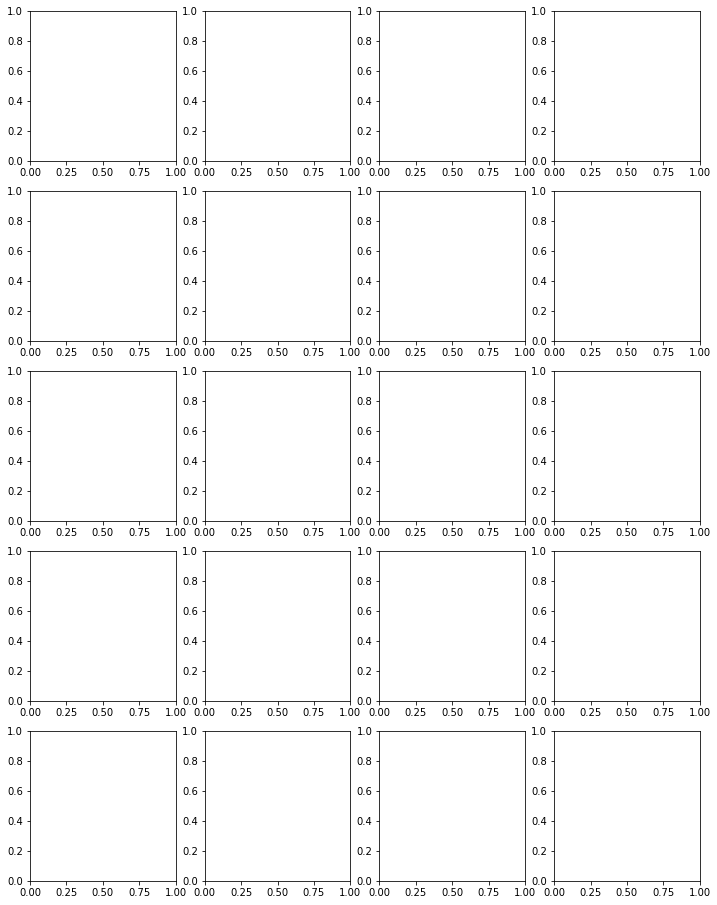

In [113]:
_,axes = plt.subplots(5,4, figsize=(12,16))
for i, ax in enumerate(axes.flat):
    imgx,imgy = train_tds[i]
    imgx.show(ax, y=imgy)

## Unet

## define Metric

In [ ]:
def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [ ]:
metrics=[accuracy, iou]

## Load resnet34

In [ ]:
def load_pretrained(model, path):
    weights = torch.load(path, map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)     
    return model

In [ ]:
'''from fastai.vision.models.unet import *
body = create_body(tvm.resnet34(True), -2) #/root/.torch/models/
body = load_pretrained(body, 'models/0.pth')'''

In [ ]:
model = DynamicUnet(tvm.resnet34(True), n_classes=2).cuda()

learn = Learner(data, model, metrics=metrics,
                loss_fn=CrossEntropyFlat())

## Transformations

In [ ]:
#((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

## Create model and fitting for size 128

In [ ]:
learn.summary()

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-3
wd=1e-8

lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=6,use_clr=(4, 6), best_save_name='unet_128_xe_best')

In [ ]:
learn.save('unet_128_6e')

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(4, 5), best_save_name='unet_128_xe_best')

In [ ]:
learn.save('unet_128_16e')

In [ ]:
learn.load('unet_128_8e')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lrs,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_128_5e_unfrozen')

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,5))

In [ ]:
learn.save('unet_128_13e_unfrozen')

## evaluation with trained resnet layers size 128

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
for i in range(0, 63):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 50

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=0.5);

## size 256

In [ ]:
bs = 32
sz = 256

In [ ]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
data = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [ ]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), IoU]

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find(start_lr=1e-8)
learn.sched.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit(lr,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_256_3e')

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_256_8e')

In [ ]:
learn.load('unet_256_8e')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lrs,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_256_3e_unfrozen')

In [ ]:
learn.fit(lrs,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_256_8e_unfrozen')

## evaluation with trained resnet layers size 256

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
for i in range(0, 31):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 10

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=1);

## size 512

In [ ]:
bs = 11
sz = 512

In [ ]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
data = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [ ]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), IoU]

In [ ]:
learn.load('unet_256_8e_unfrozen')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find(start_lr=1e-8)
learn.sched.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit(lr,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_512_3e')

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_512_8e')

In [ ]:
learn.load('unet_512_8e')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lrs,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_512_3e_unfrozen')

In [ ]:
learn.load('unet_512_3e_unfrozen')

In [ ]:
#learn.summary()
#learn.get_layer_groups

In [ ]:
learn.fit(lrs,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('unet_512_8e_unfrozen')

## evaluation with trained resnet layers size 512

In [ ]:
learn.model.eval()

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
py.shape

In [ ]:
for i in range(0, 11):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 10

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=0.5);

## size 768

In [ ]:
bs = 4
sz = 768

In [ ]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
data = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [ ]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
'''def IoU(pred, targs):
    pred = (pred > 0).astype(float)
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)
'''
def iou(input, targs):
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), IoU]

In [ ]:
learn.load('unet_512_8e_unfrozen')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find(start_lr=1e-8)
learn.sched.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,5))

In [ ]:
learn.save('unet_768_2e')

In [ ]:
learn.fit(lrs,1,cycle_len=3,use_clr=(20,5))

In [ ]:
learn.save('unet_768_3e_unfrozen')

In [ ]:
learn.load('unet_768_3e_unfrozen')

In [ ]:
learn.unfreeze()

In [ ]:
lr=1e-3

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
#learn.lr_find(start_lr=1e-8)

In [ ]:
learn.fit(lrs,1,cycle_len=3,use_clr=(20,5), best_save_name='unet_768_xe_best_unfrozen')

In [ ]:
learn.save('unet_768_6e_unfrozen')

In [ ]:
learn.fit(lrs,1,cycle_len=3,use_clr=(20,5), best_save_name='unet_768_xe_best2_unfrozen')

In [ ]:
learn.save('unet_768_9e_unfrozen')

## evaluation with trained resnet layers size 768

In [ ]:
learn.load('unet_768_3e_unfrozen')

In [ ]:
learn.model.eval()

In [ ]:
x,y = next(iter(data.test_dl))
py = to_np(learn.model(V(x)))

#x,y = next(iter(data.val_dl))
#py = to_np(learn.model(V(x)))

In [ ]:
py.shape

In [ ]:
for i in range(0, 8):
    if len(py[i][py[i]>0]):
        print(i)

In [ ]:
idx = 3

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(y[idx], ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[idx])
show_img(py[idx]>0, ax=ax, alpha=0.5);

In [ ]:
'''# TODO: refacter with this function

def get_learner(sz=128, bs=128):
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, y_test_names), path='')
    data = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
    
    models = ConvnetBuilder(arch, 0, 0, 0, custom_head=simple_up)
    learn = ConvLearner(data, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[accuracy_thresh(0.5), IoU]

    return learn'''

### Prediction for each ship so we have to split (thanks Iafoss for these convenient functions!)

In [ ]:
def enc_test(yps, names):
    for i in range(len(yps)):
        if len(yps[i][yps[i]>0]) > 0:
            masks = split_mask(yps[i])
            if len(masks) == 0:
                print('no mask returned!')
                ship_list_dict.append({'ImageId':names[i],'EncodedPixels':''})
            for mask in masks:
                ship_list_dict.append({'ImageId':names[i],'EncodedPixels':rle_encode(mask)})
        else: 
            ship_list_dict.append({'ImageId':names[i],'EncodedPixels':''})

In [ ]:
def split_mask(mask):
    threshold = 0
    threshold_obj = 0 #ignore predictions composed of "threshold_obj" pixels or less
    labled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        #if(obj.sum() > threshold_obj): 
        result.append(obj)
    return result

## create submission

In [ ]:
learn.load('unet_768_3e_unfrozen')

In [ ]:
learn.model.eval()

In [ ]:
batch_length = int(math.ceil((len(data.test_ds)/bs)/30)) #split into 30 batches because of ram limitation

mb = master_bar(range(30))
mb.first_bar.comment = f'progress on test-set'

test_iter = iter(data.test_dl)

ship_list_dict = []
py = np.empty((0, 768, 768), float)

In [ ]:
'''try:
    for i in mb:
        for j in progress_bar(range(batch_length), parent=mb):
            x,y = next(test_iter)
            py = np.append(py, to_np(learn.model(V(x))), axis=0)
        f_names = data.test_ds.fnames[batch_length * bs * i:batch_length * bs * (i+1)]
        enc_test(py, f_names)
        py = np.empty((0, 768, 768), float)
except StopIteration:
    pass'''

In [ ]:
i = 0
while True:
    print(i)
    x,y = next(test_iter)
    py = np.append(py, to_np(learn.model(V(x))), axis=0)
    
    f_names = data.test_ds.fnames[i:i+bs]
    enc_test(py, f_names)
    py = np.empty((0, 768, 768), float)
    i += bs

In [ ]:
len(ship_list_dict)

In [ ]:
pred_df = pd.DataFrame(ship_list_dict)

In [ ]:
pred_df.ImageId.nunique()

In [ ]:
len(np.unique(data.test_ds.fnames)) - pred_df.ImageId.nunique()

In [ ]:
len(pred_df), len(pred_df.groupby('ImageId', axis=0))

In [ ]:
len(os.listdir(images_test_path))

In [ ]:
len(set(os.listdir(images_test_path)))

In [ ]:
len(set(pred_df.ImageId.astype(str)))

In [ ]:
len(set(os.listdir(images_test_path)).difference(set(data.test_ds.fnames)))

In [ ]:
pred_df.ImageId = pred_df.ImageId.apply(lambda x: str(x).split('\\')[-1])

In [ ]:
pred_df.to_csv('submission.csv',index=False)